In [43]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

In [44]:
animes = pd.read_csv('anime_filtered.csv') # 14474 rows

In [45]:
users = pd.read_csv('users_filtered.csv', keep_default_na=False) # 116133 rows

In [46]:
animelists = pd.read_csv('animelists_filtered.csv', keep_default_na=False) # 35802006 rows

In [47]:
# calculating watch time in minutes and adding it to new column for anime
def convert_to_mins(string):
    regex = re.search('((\d+) hr\.)?( ?(\d+) min\.)?( ?(\d+) sec\.)?( per ep\.)?', string)
    hours = 0 if regex.group(2) is None else int(regex.group(2))
    minutes = 0 if regex.group(4) is None else int(regex.group(4))
    seconds = 0 if regex.group(6) is None else int(regex.group(6))
    return hours * 60 + minutes + seconds / 60

animes['duration_min'] = animes['duration'].apply(convert_to_mins)

### USERS

In [48]:
users['birth_date'] = pd.to_datetime(users['birth_date'], errors='coerce')
users['last_online'] = pd.to_datetime(users['last_online'], errors='coerce')
users['join_date'] = pd.to_datetime(users['join_date'], errors='coerce')

In [49]:
# dropping users with invalid and obviously incorrect dates
users = users.dropna(subset=['birth_date', 'last_online', 'join_date'])

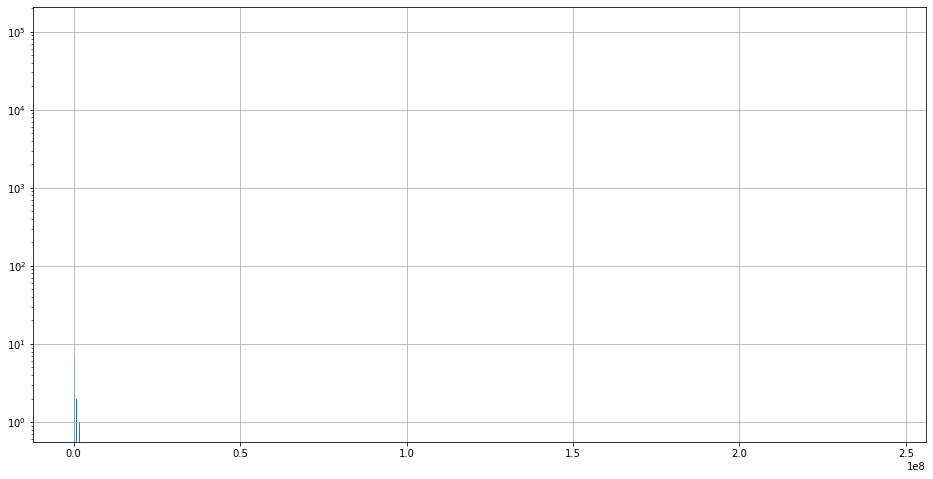

In [50]:
# check number of watched episodes
users['stats_episodes'].hist(bins=5000, figsize=(16, 8))  

plt.gca().set_yscale('log')

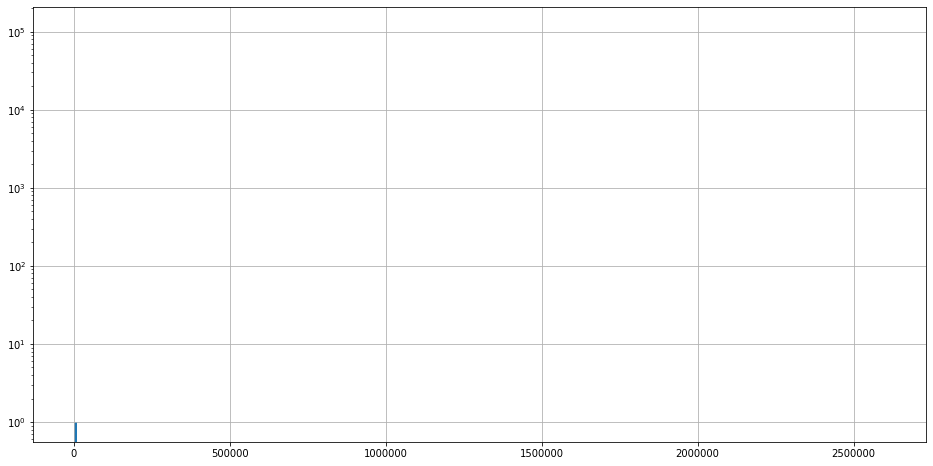

In [51]:
# check number of days spent watching
users['user_days_spent_watching'].hist(bins=5000, figsize=(16, 8))

plt.gca().set_yscale('log')

In [52]:
# these users have banned:
# warrose: way too many animes with unsually high no of rewatches per episode (as a result no of days spent watching anime is unusually high-> skews data)
# ban DeliberatorEVA: sizeable number of animes with a unusually high no of rewatches per episode; not scored any of the anime; no info in my_start_date and my_end_date columns
banned_users = pd.array(['warrose','DeliberatorEVA'],dtype=str)

# delete banned users from users DataFrame
users_filtered = users[~(users['username'].isin(banned_users))]

In [53]:
enriched_animelists = pd.merge(animelists, animes[['anime_id', 'duration_min', 'title']], on='anime_id')
grouped_animelists = enriched_animelists.groupby('username')

usernames_arr = animelists['username'].unique()
usernames = pd.Series(data=usernames_arr,index=usernames_arr)

users_stats_episodes = usernames.apply(lambda x: grouped_animelists.get_group(x)['my_watched_episodes'].sum()).to_frame(name='stats_episodes')


def count_to_days(group):
    return (group['my_watched_episodes'] * group['duration_min']).sum() / (60 * 24)

# calculate days_spent_watching from duration_min's column
user_days_spent_watching = usernames.apply(lambda x: count_to_days(enriched_animelists.loc[grouped_animelists.groups[x]])).to_frame(name='days_spent_watching')

In [54]:
users_merged = pd.merge(users_filtered[['username']], users_stats_episodes, left_on='username', right_index=True)

# fixing number of episodes
users_filtered['stats_episodes'] = users_merged['stats_episodes']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


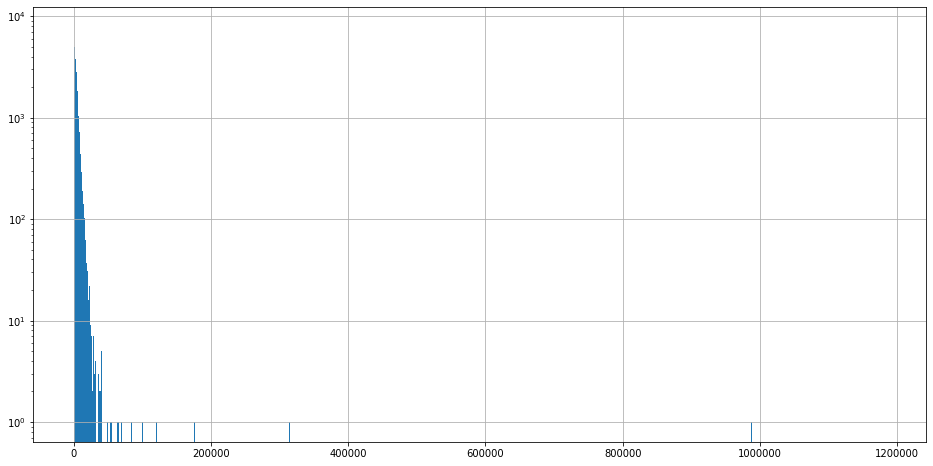

In [55]:
users_filtered['stats_episodes'].hist(bins=5000, figsize=(16, 8))

plt.gca().set_yscale('log')

In [56]:
merged_days_spent_watching = pd.merge(users_filtered[['username']], user_days_spent_watching, left_on='username', right_index=True)

# fixing days watch times
users_filtered['user_days_spent_watching'] = merged_days_spent_watching['days_spent_watching']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [57]:
# filtering users with less than  4 hours watching:  2105
users_filtered = users_filtered[users_filtered['user_days_spent_watching'] > 1/2]

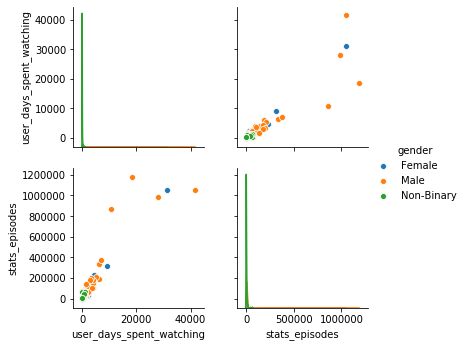

In [58]:
# scatterplot shows a few users with very large animelists
sns.pairplot(users_filtered[['user_days_spent_watching','gender', 'birth_date', 'join_date','last_online', 'stats_episodes']], hue='gender')

In [59]:
# delete 176 users with 70k episodes or more -> too few users and they mess with graphs 
users_small = users_filtered[users_filtered['stats_episodes'] < 70000]

In [83]:
users_arr = users_small['username'].unique()
users_series = pd.Series(data=users_arr, index=users_arr)


grouped_lists = animelists[animelists['username'].isin(users_series)].groupby('username')
users_last_animelist_update = users_series.apply(lambda x: grouped_lists.get_group(x)['my_last_updated'].max()).to_frame(name='last_list_update')

users_last_animelist_update['last_list_update'] = pd.to_datetime(users_last_animelist_update['last_list_update'])

users_updated = pd.merge(users, users_last_animelist_update, left_on='username', right_index=True)


,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,last_online
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,2013-05-05 14:38:12
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0,2018-05-04 14:59:17
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,2017-07-10 06:52:54
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,2014-05-12 06:42:27
4,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0,2011-11-26 11:15:25
5,Bas_G,5015094,35,114,6,20,175,30.81,Male,"Nijmegen, Nederland",1999-10-24,,2015-11-26,1900-05-10 13:53:00,7.86,0.0,1847.0,2018-05-10 20:53:37
6,HimeAria,3129315,2,87,2,0,28,20.12,Female,Poland,1996-09-26,,2013-09-08,1900-04-27 10:52:00,8.23,0.0,1314.0,2018-01-14 13:05:42
7,Skallington,326733,0,3,0,0,0,4.32,Male,Norberg Sweden,1991-03-15,,2010-05-09,2010-05-12 06:29:00,10.00,7.0,251.0,2010-05-10 00:00:16
8,Slimak,61677,79,224,0,3,84,126.17,Male,Poland,1988-02-21,,2008-05-18,1900-05-01 05:04:00,7.77,2.0,7472.0,2018-05-01 12:05:21
9,Elysiun,5927342,7,4,0,0,4,2.09,Male,Nebraska,1984-11-16,,2016-12-25,2017-03-11 21:37:00,7.40,0.0,121.0,2017-03-12 05:37:27


In [87]:
users_updated = users_updated.drop(columns=['last_online'], axis=1)
users_updated = users_updated.rename(columns={'last_list_update':'last_online'})
users_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114005 entries, 0 to 116132
Data columns (total 17 columns):
username                    114005 non-null object
user_id                     114005 non-null int64
user_watching               114005 non-null int64
user_completed              114005 non-null int64
user_onhold                 114005 non-null int64
user_dropped                114005 non-null int64
user_plantowatch            114005 non-null int64
user_days_spent_watching    114005 non-null float64
gender                      114005 non-null object
location                    114005 non-null object
birth_date                  114005 non-null datetime64[ns]
access_rank                 114005 non-null object
join_date                   114005 non-null datetime64[ns]
stats_mean_score            114005 non-null float64
stats_rewatched             114005 non-null float64
stats_episodes              114005 non-null float64
last_online                 114005 non-null datetime64[ns]


In [88]:
users_updated.to_csv('users_cleaned.csv', index=False, sep=',', encoding='utf-8')

### ANIMES

In [62]:
# extract air year from aired column
animes['aired_from_year'] = pd.to_datetime(animes['aired'].apply(lambda x: ast.literal_eval(x.replace('\'', '"'))['from']), errors='coerce').dt.year

In [63]:
# for anime with airing year in aired_string column, use that year to fill null aired_from_year columns 
years_from_string = animes['aired_string'].str.extract(r'(\d{4})')

animes.loc[animes['aired_from_year'].isnull(), 'aired_from_year'] = years_from_string[animes['aired_from_year'].isnull()]

In [64]:
# delete animes with no genre
delete_filter = (animes['genre'].isnull())
animes_remaining = animes[~(delete_filter)]

In [65]:
animes_remaining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14410 entries, 0 to 14473
Data columns (total 33 columns):
anime_id           14410 non-null int64
title              14410 non-null object
title_english      5710 non-null object
title_japanese     14378 non-null object
title_synonyms     8915 non-null object
image_url          14318 non-null object
type               14410 non-null object
source             14410 non-null object
episodes           14410 non-null int64
status             14410 non-null object
airing             14410 non-null bool
aired_string       14410 non-null object
aired              14410 non-null object
duration           14410 non-null object
rating             14410 non-null object
score              14410 non-null float64
scored_by          14410 non-null int64
rank               12845 non-null float64
popularity         14410 non-null int64
members            14410 non-null int64
favorites          14410 non-null int64
background         1055 non-null objec

In [66]:
animes_remaining.to_csv('animes_cleaned.csv', index=False, sep=',', encoding='utf-8')

### ANIMELISTS

In [67]:
#convert to datetime
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'], unit='s')

In [68]:
# convert to float data type
animelists['my_rewatching'] = animelists['my_rewatching'].replace([''],'0')
animelists['my_rewatching'] = animelists['my_rewatching'].astype(str).astype(float)

In [69]:
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'], unit='s')

In [70]:
# animes with episode count = 0 and status = Currently airing -> user is able to manually input the no of episodes watched (since the official episode count is unknown)
manual_entry_animes = pd.array([966,21,6149,34866,34566,13457,35444,8687,30151,1199,35510,235,2406],dtype=np.dtype("int64"))

In [71]:
animelists_filtered = animelists[~((animelists['anime_id'].isin(manual_entry_animes)) & (animelists['my_watched_episodes'] > 2444))]# As of November 2015, there have been 2444+ episodes aired (for the longest running anime Sazae-san) -> 2444 is the benchmark !!! 
# 35801949 rows

In [72]:
# animelists_filtered[animelists_filtered['my_watched_episodes'] == 9001]['my_last_updated'].dt.day.value_counts().sort_index() 

# all were updated in 2014
#  September 2014 a moderator's account got comprimised and the episode count of a lot of entries changed to 9001 episodes. If people added an entry as "completed" to their list, the episode count was automatically filled with the number of episodes (9001 in this case) 
# 350 episodes updated in September (9)
# users also reported a changed in episode count in late August 
# ==> delete all rows with my_watched_episodes = 9001

animelists_filtered_2 = animelists_filtered[~(animelists_filtered['my_watched_episodes'] == 9001)]
# 35801348

In [73]:
# only keep rows of filtered users
users_small_series= pd.Series(users_small['username'].unique())
animelists_filtered_3 = animelists_filtered_2[animelists_filtered_2['username'].isin(users_small_series)]

In [74]:
filtered_episode_cnt_merged = pd.merge(animelists_filtered_3,animes_remaining[['anime_id','episodes','status']],how='inner',on='anime_id')

In [75]:
# my_watched_episodes column contains weird data:
# no of watched episodes > anime episode count
# no of watched episodes > 0 for plan to watch anime
# no of watched episodes unusually high for ongoing anime (whereby users are allowed to input no of watched episodes)
def fix_watched_episodes(anime_status,total_episodes,my_status,watched_episodes,my_rewatching):
    total_ep_with_rewatch = max(int(my_rewatching), 1)*total_episodes

    if my_status != 6: #1: watching/ 2: completed/ 3: on hold/ 4: dropped/
        if anime_status == 'Finished Airing':
            if total_episodes != 0 and total_ep_with_rewatch < watched_episodes:
                return total_episodes
            else:
                return watched_episodes
        elif anime_status == 'Not aired yet':
            return 0
        else: # 'Currently Airing'
            if total_episodes != 0 and total_ep_with_rewatch < watched_episodes:
                return total_episodes
            else:
                return watched_episodes
    else: # 6: plan to watch
        return 0
    
filtered_episode_cnt_merged['my_watched_episodes'] = filtered_episode_cnt_merged.apply(lambda x:fix_watched_episodes(x['status'],x['episodes'],x['my_status'],x['my_watched_episodes'],x['my_rewatching']),axis=1)

In [76]:
filtered_episode_cnt_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35679134 entries, 0 to 35679133
Data columns (total 13 columns):
username               object
anime_id               int64
my_watched_episodes    int64
my_start_date          object
my_finish_date         object
my_score               int64
my_status              int64
my_rewatching          float64
my_rewatching_ep       int64
my_last_updated        datetime64[ns]
my_tags                object
episodes               int64
status                 object
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 3.7+ GB


In [77]:
filtered_episode_cnt_merged.to_csv('animelists_cleaned.csv',index=False,sep=',',encoding='utf-8')